
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [38]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

# Bibliotecas para preparação dos dados
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode
from imblearn.over_sampling import RandomOverSampler

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import gensim
import fasttext
from gensim.models import KeyedVectors

In [9]:
# Carregando dataset pre-processado e balanceado
df = pd.read_csv('../datasets/buscape_preprocessed_balanced.csv')

In [15]:
word_vectors = KeyedVectors.load_word2vec_format('../embeddings/wiki.pt.vec', binary=False)

In [16]:
texts = df['review_text']
labels = df['rating']

In [17]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [18]:
def generate_sentence_embedding(text):
    words = text.split()
    embeddings = [word_vectors[word] for word in words if word in word_vectors]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(300)  # Use zeros for out-of-vocabulary words

In [19]:
train_embeddings = np.array([generate_sentence_embedding(text) for text in train_texts])
test_embeddings = np.array([generate_sentence_embedding(text) for text in test_texts])

In [27]:
model = Sequential()
model.add(Input(300,)),
model.add(Dense(128, activation='relu')),
model.add(Dropout(0.05)),
model.add(Dense(64, activation='relu')),
model.add(Dropout(0.05)),
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               38528     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 46,849
Trainable params: 46,849
Non-trainable params: 0
_________________________________________________________________


In [46]:
LEARNING_RATE = 5e-4
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['acc']
BATCH_SIZE = 32
EPOCHS = 10
CHECKPOINT = ModelCheckpoint(filepath='../weights/fast_text_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

In [47]:
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [48]:
model_history = model.fit(
    train_embeddings, 
    train_labels, 
    verbose=1, 
    batch_size=BATCH_SIZE,  
    epochs=EPOCHS,
    validation_data=(train_embeddings, train_labels),
    callbacks=CALLBACKS
)

Epoch 1/10
3334/3341 [============================>.] - ETA: 0s - loss: 0.1778 - acc: 0.9304
Epoch 1: val_loss improved from inf to 0.16141, saving model to ../weights/fast_text_weights.hdf5
3341/3341 [==============================] - 10s 3ms/step - loss: 0.1778 - acc: 0.9304 - val_loss: 0.1614 - val_acc: 0.9364
Epoch 2/10
3336/3341 [============================>.] - ETA: 0s - loss: 0.1734 - acc: 0.9336
Epoch 2: val_loss did not improve from 0.16141
3341/3341 [==============================] - 8s 2ms/step - loss: 0.1734 - acc: 0.9336 - val_loss: 0.1637 - val_acc: 0.9367
Epoch 3/10
3337/3341 [============================>.] - ETA: 0s - loss: 0.1658 - acc: 0.9369
Epoch 3: val_loss improved from 0.16141 to 0.14262, saving model to ../weights/fast_text_weights.hdf5
3341/3341 [==============================] - 8s 3ms/step - loss: 0.1658 - acc: 0.9369 - val_loss: 0.1426 - val_acc: 0.9476
Epoch 4/10
3325/3341 [============================>.] - ETA: 0s - loss: 0.1606 - acc: 0.9393
Epoch 4: va

In [49]:
NB_START_EPOCHS = 10

In [50]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

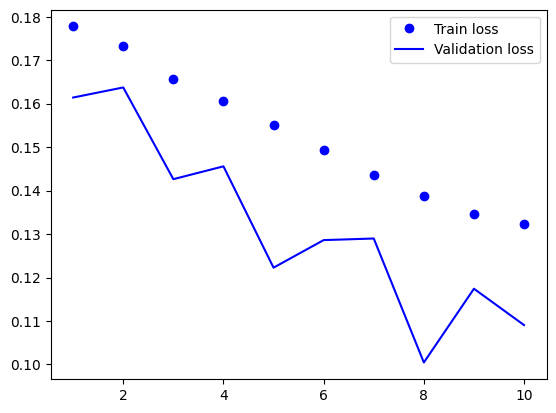

In [51]:
eval_metric(model_history, 'loss')

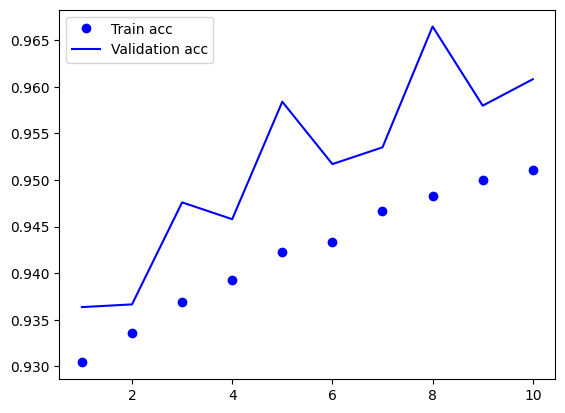

In [52]:
eval_metric(model_history, 'acc')

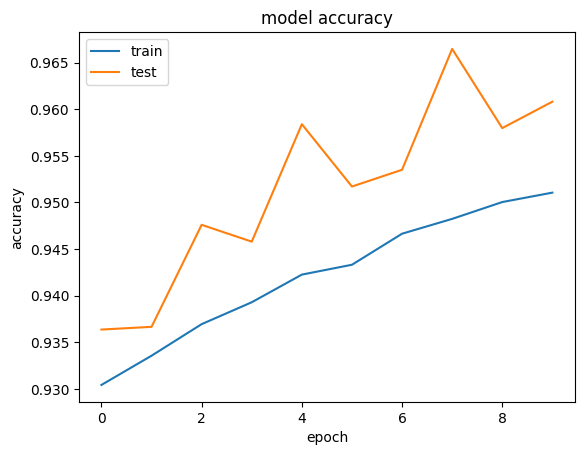

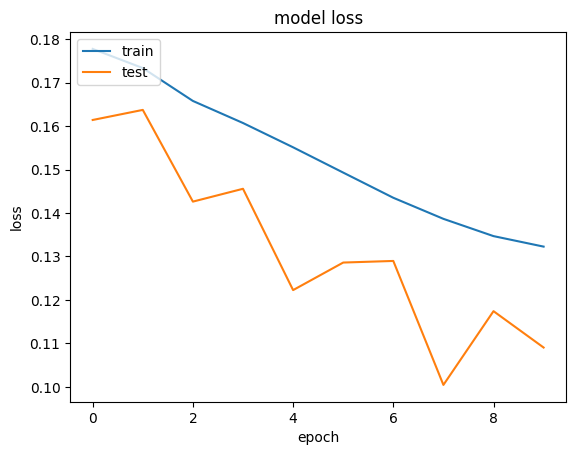

In [53]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
predict = np.round(model.predict(test_embeddings))

836/836 [==============================] - 1s 765us/step


In [55]:
accuracy_score(test_labels, predict)

0.9414823960788715

In [56]:
print(classification_report(test_labels, predict))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     13347
           1       0.94      0.94      0.94     13380

    accuracy                           0.94     26727
   macro avg       0.94      0.94      0.94     26727
weighted avg       0.94      0.94      0.94     26727



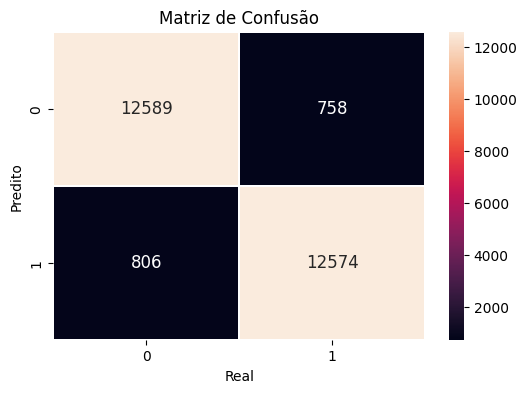

In [57]:
mc = confusion_matrix(test_labels, predict)
plt.figure(figsize=(6,4))
sbn.heatmap(mc, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
plt.title("Matriz de Confusão", fontsize=12)
plt.xlabel('Real')
plt.ylabel('Predito')
plt.show()